## Transfer-Learning 






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/'Colab Notebooks'/

/content/drive/MyDrive/Colab Notebooks


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from keras.utils import np_utils
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [5]:
#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [6]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [7]:
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(x_train)

In [8]:
y_train = np_utils.to_categorical(y_train, 100)
y_test = np_utils.to_categorical(y_test, 100)

In [9]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_9 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, None, None, None)  0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
history = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=12,
                                  validation_data=(x_test, y_test))

<ipython-input-11-a291a3b3c760>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/12
781/781 [==============================] - 516s 630ms/step - loss: 2.0094 - accuracy: 0.4811 - val_loss: 1.0603 - val_accuracy: 0.6859
Epoch 2/12
781/781 [==============================] - 489s 626ms/step - loss: 1.1639 - accuracy: 0.6643 - val_loss: 0.8524 - val_accuracy: 0.7416
Epoch 3/12
781/781 [==============================] - 481s 616ms/step - loss: 0.9731 - accuracy: 0.7134 - val_loss: 0.7813 - val_accuracy: 0.7641
Epoch 4/12
781/781 [==============================] - 489s 626ms/step - loss: 0.8711 - accuracy: 0.7403 - val_loss: 0.7325 - val_accuracy: 0.7785
Epoch 5/12
781/781 [==============================] - 481s 616ms/step - loss: 0.8001 - accuracy: 0.7587 - val_loss: 0.7361 - val_accuracy: 0.7817
Epoch 6/12
781/781 [==============================] - 481s 616ms/step - loss: 0.7396 - accuracy: 0.7778 - val_loss: 0.7325 - val_accuracy: 0.7784
Epoch 7/12
781/781 [==============================] - 489s 626ms/step - loss: 0.6929 - accuracy: 0.7879 - val_loss: 0.7067 -

In [ ]:
#model.save_weights("New_cifar100.h5")

In [12]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 35s 111ms/step - loss: 0.7209 - accuracy: 0.7982


[0.7208670377731323, 0.7982000112533569]

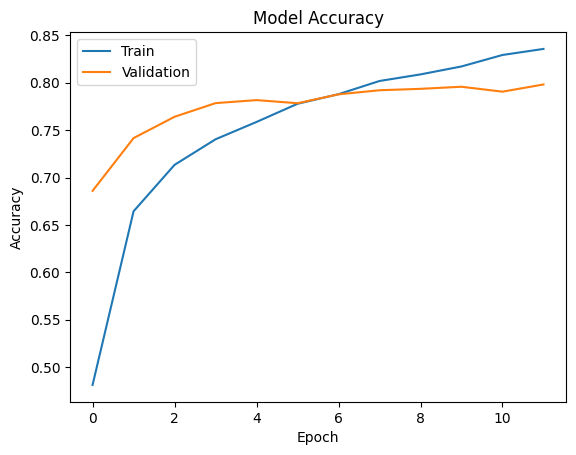

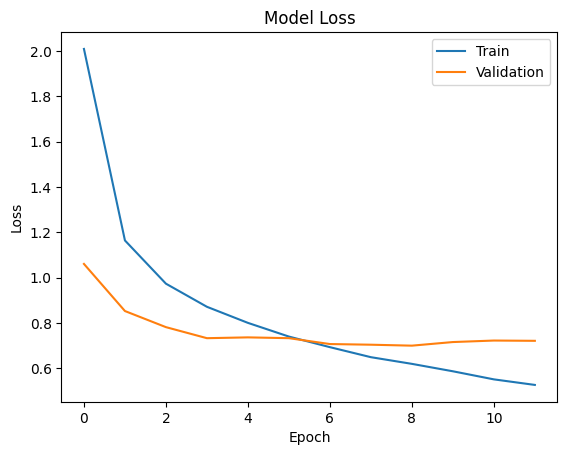

In [13]:
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [14]:
#model.save('New_cifar100.h5')

In [15]:
from tensorflow.keras.models import load_model
new_model = load_model('New_cifar100.h5')

In [16]:
new_model.evaluate(x_test, y_test, batch_size=10, verbose=1)

1000/1000 [==============================] - 39s 38ms/step - loss: 0.7209 - accuracy: 0.7982


[0.7208674550056458, 0.7982000112533569]

In [17]:
y_pred = new_model.predict(x_test)

313/313 [==============================] - 33s 103ms/step


In [18]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [19]:
y_true = np.argmax(y_test, axis=1)

In [20]:
acc = (np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)))*100
print('Accuracy:', acc)

Accuracy: 79.82000000000001


In [21]:
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true,y_pred_classes)
print((cm))

[[87  0  0 ...  0  0  0]
 [ 0 90  0 ...  0  0  0]
 [ 0  0 71 ...  0  3  1]
 ...
 [ 0  0  0 ... 88  1  0]
 [ 0  0  1 ...  0 65  0]
 [ 0  0  1 ...  0  0 94]]


In [22]:
cr=classification_report(y_true,y_pred_classes)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       100
           1       0.83      0.90      0.87       100
           2       0.69      0.71      0.70       100
           3       0.73      0.72      0.72       100
           4       0.72      0.69      0.70       100
           5       0.88      0.80      0.84       100
           6       0.93      0.79      0.85       100
           7       0.77      0.80      0.78       100
           8       0.96      0.90      0.93       100
           9       0.91      0.89      0.90       100
          10       0.75      0.55      0.64       100
          11       0.53      0.44      0.48       100
          12       0.86      0.89      0.88       100
          13       0.81      0.81      0.81       100
          14       0.78      0.83      0.81       100
          15       0.80      0.87      0.83       100
          16       0.86      0.87      0.87       100
          17       0.99    

In [23]:
from collections import Counter
c=Counter(list(np.ravel(y_pred_classes)))
c.most_common

<bound method Counter.most_common of Counter({65: 152, 46: 147, 72: 140, 59: 126, 99: 126, 18: 123, 84: 122, 29: 121, 57: 120, 87: 119, 61: 115, 54: 115, 77: 114, 89: 114, 80: 113, 33: 111, 71: 111, 73: 111, 93: 110, 15: 109, 63: 109, 67: 109, 1: 108, 21: 107, 97: 106, 14: 106, 62: 106, 32: 105, 76: 105, 28: 105, 68: 104, 79: 104, 7: 104, 2: 103, 45: 103, 12: 103, 94: 102, 51: 101, 69: 101, 40: 101, 16: 101, 58: 101, 90: 101, 37: 101, 60: 101, 25: 100, 42: 100, 13: 100, 36: 100, 3: 99, 92: 98, 9: 98, 98: 98, 38: 98, 48: 98, 49: 97, 82: 97, 95: 97, 34: 97, 23: 96, 43: 96, 30: 96, 4: 96, 66: 96, 26: 96, 86: 96, 53: 95, 20: 95, 0: 94, 8: 94, 47: 94, 41: 93, 22: 93, 81: 92, 91: 92, 39: 91, 52: 91, 5: 91, 24: 90, 96: 90, 75: 89, 78: 89, 44: 89, 85: 88, 56: 87, 31: 86, 50: 86, 6: 85, 74: 85, 88: 84, 11: 83, 55: 83, 83: 82, 19: 81, 70: 80, 17: 79, 10: 73, 35: 73, 64: 72, 27: 66})>